In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from cmcrameri.cm import *
import numpy as np
import os
import netCDF4 as nc
from mpl_toolkits.axes_grid1 import make_axes_locatable

unit_Rjup = 69.911e3 # m
unit_Rear = 6.371e3  # m
unit_Mjup = 1.898e27 # kg
unit_Mear = 5.972e24 # kg

R_earth = 6.371e6
M_earth = 5.972e24
bar = 1e5 # Pa

data_dir = "/home/n/nichollsh/thesis_pipeline/data/"

# %matplotlib widget
%config InlineBackend.figure_format = 'retina'

In [2]:
z19 = data_dir+"Mass-radius/Zeng2019/"

# Set paths
mr_curves = {
    r"Fe":                  z19+"massradiusFe.txt",
    r"Earth-like":          z19+"massradiusEarthlikeRocky.txt",
    r"MgSiO$_3$":           z19+"massradiusmgsio3.txt",
    # r"H$_2$O, 300 K":     z19+"massradius_100percentH2O_300K_1mbar.txt",
    # r"H$_2$":             z19+"massradiushydrogen.txt",

    r"50% H$_2$O, 300K":    z19+"massradius_50percentH2O_300K_1mbar.txt",
    r"1.0% H$_2$, 500K":    z19+"Earthlike1h500K1mbar.txt",
    r"0.3% H$_2$, 700K":    z19+"Earthlike1h700K1mbar.txt",
}

# Replace mr_curves with the data
for k in mr_curves.keys():
    data = np.loadtxt(mr_curves[k]).T
    mask = np.argsort(data[0])
    mr_curves[k] = [data[0][mask],data[1][mask]]


In [3]:
# Exoplanets
input_filename = data_dir+"exoplanet_eu.csv"
exo_raw = pd.read_csv(input_filename,delimiter=',')
exo_dat = exo_raw.loc[exo_raw['planet_status'] == 'Confirmed']

# Show values
exo_dat

,name,planet_status,mass,mass_error_min,mass_error_max,mass_sini,mass_sini_error_min,mass_sini_error_max,radius,radius_error_min,...,star_sp_type,star_age,star_age_error_min,star_age_error_max,star_teff,star_teff_error_min,star_teff_error_max,star_detected_disc,star_magnetic_field,star_alternate_names
0,109 Psc b,Confirmed,5.743,0.28900,1.01100,6.3830,0.07800,0.07800,1.152,NaN,...,G5 IV,6.90,0.60,0.60,5600.0,80.000,80.000,NaN,NaN,HD 10697
1,112 Psc b,Confirmed,NaN,0.00500,0.00400,0.0330,0.00500,0.00400,NaN,NaN,...,G0IV,NaN,NaN,NaN,5986.0,105.437,105.437,NaN,NaN,HD 12235
2,112 Psc c,Confirmed,9.866,1.78100,3.19000,NaN,NaN,NaN,NaN,NaN,...,G0IV,NaN,NaN,NaN,5986.0,105.437,105.437,NaN,NaN,HD 12235
3,11 Com Ab,Confirmed,NaN,1.53491,1.53491,16.1284,1.53491,1.53491,NaN,NaN,...,G8III,NaN,NaN,NaN,4742.0,100.000,100.000,NaN,NaN,HD 107383
4,11 UMi b,Confirmed,NaN,1.10000,1.10000,11.0873,1.10000,1.10000,NaN,NaN,...,K4III,1.56,0.54,0.54,4340.0,70.000,70.000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7602,ZTF J1406+1222 Ab,Confirmed,50.000,NaN,NaN,NaN,NaN,NaN,0.292,NaN,...,PSR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7603,ZTF J1622+47 b,Confirmed,61.000,19.00000,19.00000,NaN,NaN,NaN,0.980,0.02,...,sdB,NaN,NaN,NaN,29000.0,NaN,NaN,NaN,NaN,"PG 1621+476, ZTF J162256.66+473051.1"
7604,ZTF J1637+49 b,Confirmed,23.000,8.00000,8.00000,NaN,NaN,NaN,0.680,0.07,...,DA,NaN,NaN,NaN,11200.0,300.000,300.000,NaN,NaN,ZTF J163743.49+491740.4
7605,ZTF J1828+2308 b,Confirmed,19.500,0.80000,0.80000,NaN,NaN,NaN,1.020,0.02,...,DA,NaN,NaN,NaN,15900.0,75.000,75.000,NaN,NaN,ZTF J182848.77+230838.0


In [4]:
solar_sys_file = open(data_dir+"solar_system.tsv",'r')
ss_lines = solar_sys_file.readlines()
solar_sys_file.close()

solar_system = {}

# Add bodies
for i,h in enumerate(ss_lines[1].split()[1:]):
    k = h.capitalize()
    solar_system[k] = {"index":i,"name":k}

# For each body
for k in solar_system.keys():
    i = solar_system[k]["index"]

    # For each parameter
    for l in ss_lines[2:]:
        split = l.split()
        param = str(split[0])
        val   = split[i+1]

        if (param == "Symbol"):
            solar_system[k]["symbol"] = str(val)
        else:
            val = float(val)
            match param:
                case "Mass(10^24kg)":
                    solar_system[k]["mass"] = val / 5.97  # M_earth
                case "Diameter(km)":
                    solar_system[k]["radius"] = val / 12756# R_earth
                case "MeanTemperature(C)":
                    solar_system[k]["temp_calculated"] =  val + 273.15 # K
                case "OrbitalPeriod(days)":
                    solar_system[k]["orbital_period"] = val   # day
                case "DistancefromSun(10^6km)":
                    solar_system[k]["semi_major_axis"] = val / 149.6  # AU
                case "OrbitalEccentricity":
                    solar_system[k]["eccentricity"] = val

    print(solar_system[k])



{'index': 0, 'name': 'Mercury', 'mass': 0.05527638190954774, 'radius': 0.38248667293822514, 'semi_major_axis': 0.3870320855614973, 'orbital_period': 88.0, 'eccentricity': 0.206, 'temp_calculated': 440.15, 'symbol': '☿'}
{'index': 1, 'name': 'Venus', 'mass': 0.8157453936348409, 'radius': 0.9488867983693948, 'semi_major_axis': 0.7232620320855615, 'orbital_period': 224.7, 'eccentricity': 0.007, 'temp_calculated': 737.15, 'symbol': '♀︎'}
{'index': 2, 'name': 'Earth', 'mass': 1.0, 'radius': 1.0, 'semi_major_axis': 1.0, 'orbital_period': 365.2, 'eccentricity': 0.017, 'temp_calculated': 288.15, 'symbol': '⊕'}
{'index': 3, 'name': 'Moon', 'mass': 0.012227805695142379, 'radius': 0.2724208215741612, 'semi_major_axis': 0.0025668449197860962, 'orbital_period': 27.3, 'eccentricity': 0.055, 'temp_calculated': 253.14999999999998, 'symbol': '☾'}
{'index': 4, 'name': 'Mars', 'mass': 0.10753768844221107, 'radius': 0.5324553151458138, 'semi_major_axis': 1.5240641711229947, 'orbital_period': 687.0, 'eccen

In [5]:
# scale factor, log axis, unit name
units = {
    # input vars
    "frac_core"     : [100,       False  ,"Core fraction [mass%]"],
    "frac_atm"      : [100,       False  ,"Atm fraction [mass%]"],
    "mass_tot"      : [1.0,       False  ,r"Total mass [M$_\oplus$]"],
    "instellation"  : [1.0,       False  ,r"Instellation [S$_0$]"],
    "metal_C"       : [1.0,       True   ,"C/H mol"],
    "metal_S"       : [1.0,       True   ,"S/H mol"],
    "metal_O"       : [1.0,       True   ,"O/H mol"],

    # output vars
    "p_surf"        : [1e-5,      True   ,r"$p_s$ [bar]"], # output, Pa -> bar
    "t_surf"        : [1,         False  ,r"$T_s$ [K]"],
    "r_surf"        : [1/R_earth, False  ,r"$R_s$ [R$_\oplus$]"],
    "μ_surf"        : [1e3,       False  ,r"$\mu_s$ [g/mol]"],

    "r_phot"        : [1/R_earth, False  ,r"$R_p$ [R$_\oplus$]"],
    "μ_phot"        : [1e3,       False  ,r"$\mu_p$ [g/mol]"],
    "t_phot"        : [1,         False  ,r"$T_p$ [K]"],
    "Kzz_max"       : [1e4,       True   ,r"$K_{zz}$ [cm$^2$/s]"],

    "succ"          : [1,         False   ,"Success"], # succ=1, fail=-1
}


In [6]:
# Read both of the CSV files
output_dir = "../out"
gridpoints_df = pd.read_csv(os.path.join(output_dir, "gridpoints.csv"), sep=',')
results_df = pd.read_csv(os.path.join(output_dir, "result_table.csv"), sep=',')

# Merge the dataframes on index
data = pd.merge(gridpoints_df, results_df, on="index")

gridsize = len(data)
print(gridsize)

# Define input and output variables
input_vars  = list(gridpoints_df.keys())
output_vars = list(results_df.keys())

input_vars.remove("index")
output_vars.remove("index")

384


In [7]:
# Read NetCDF output file
ds = nc.Dataset(os.path.join(output_dir,"result_profs.nc"))

data_t = np.array(ds["t"][:,:], copy=True, dtype=float)
data_p = np.array(ds["p"][:,:], copy=True, dtype=float)
data_r = np.array(ds["r"][:,:], copy=True, dtype=float)

ds.close()


/tmp/user/27339/ipykernel_1266740/3697438568.py:47: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yticklabels([])
/tmp/user/27339/ipykernel_1266740/3697438568.py:47: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yticklabels([])
/tmp/user/27339/ipykernel_1266740/3697438568.py:47: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yticklabels([])
/tmp/user/27339/ipykernel_1266740/3697438568.py:47: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yticklabels([])
/tmp/user/27339/ipykernel_1266740/3697438568.py:55: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.tight_layout()


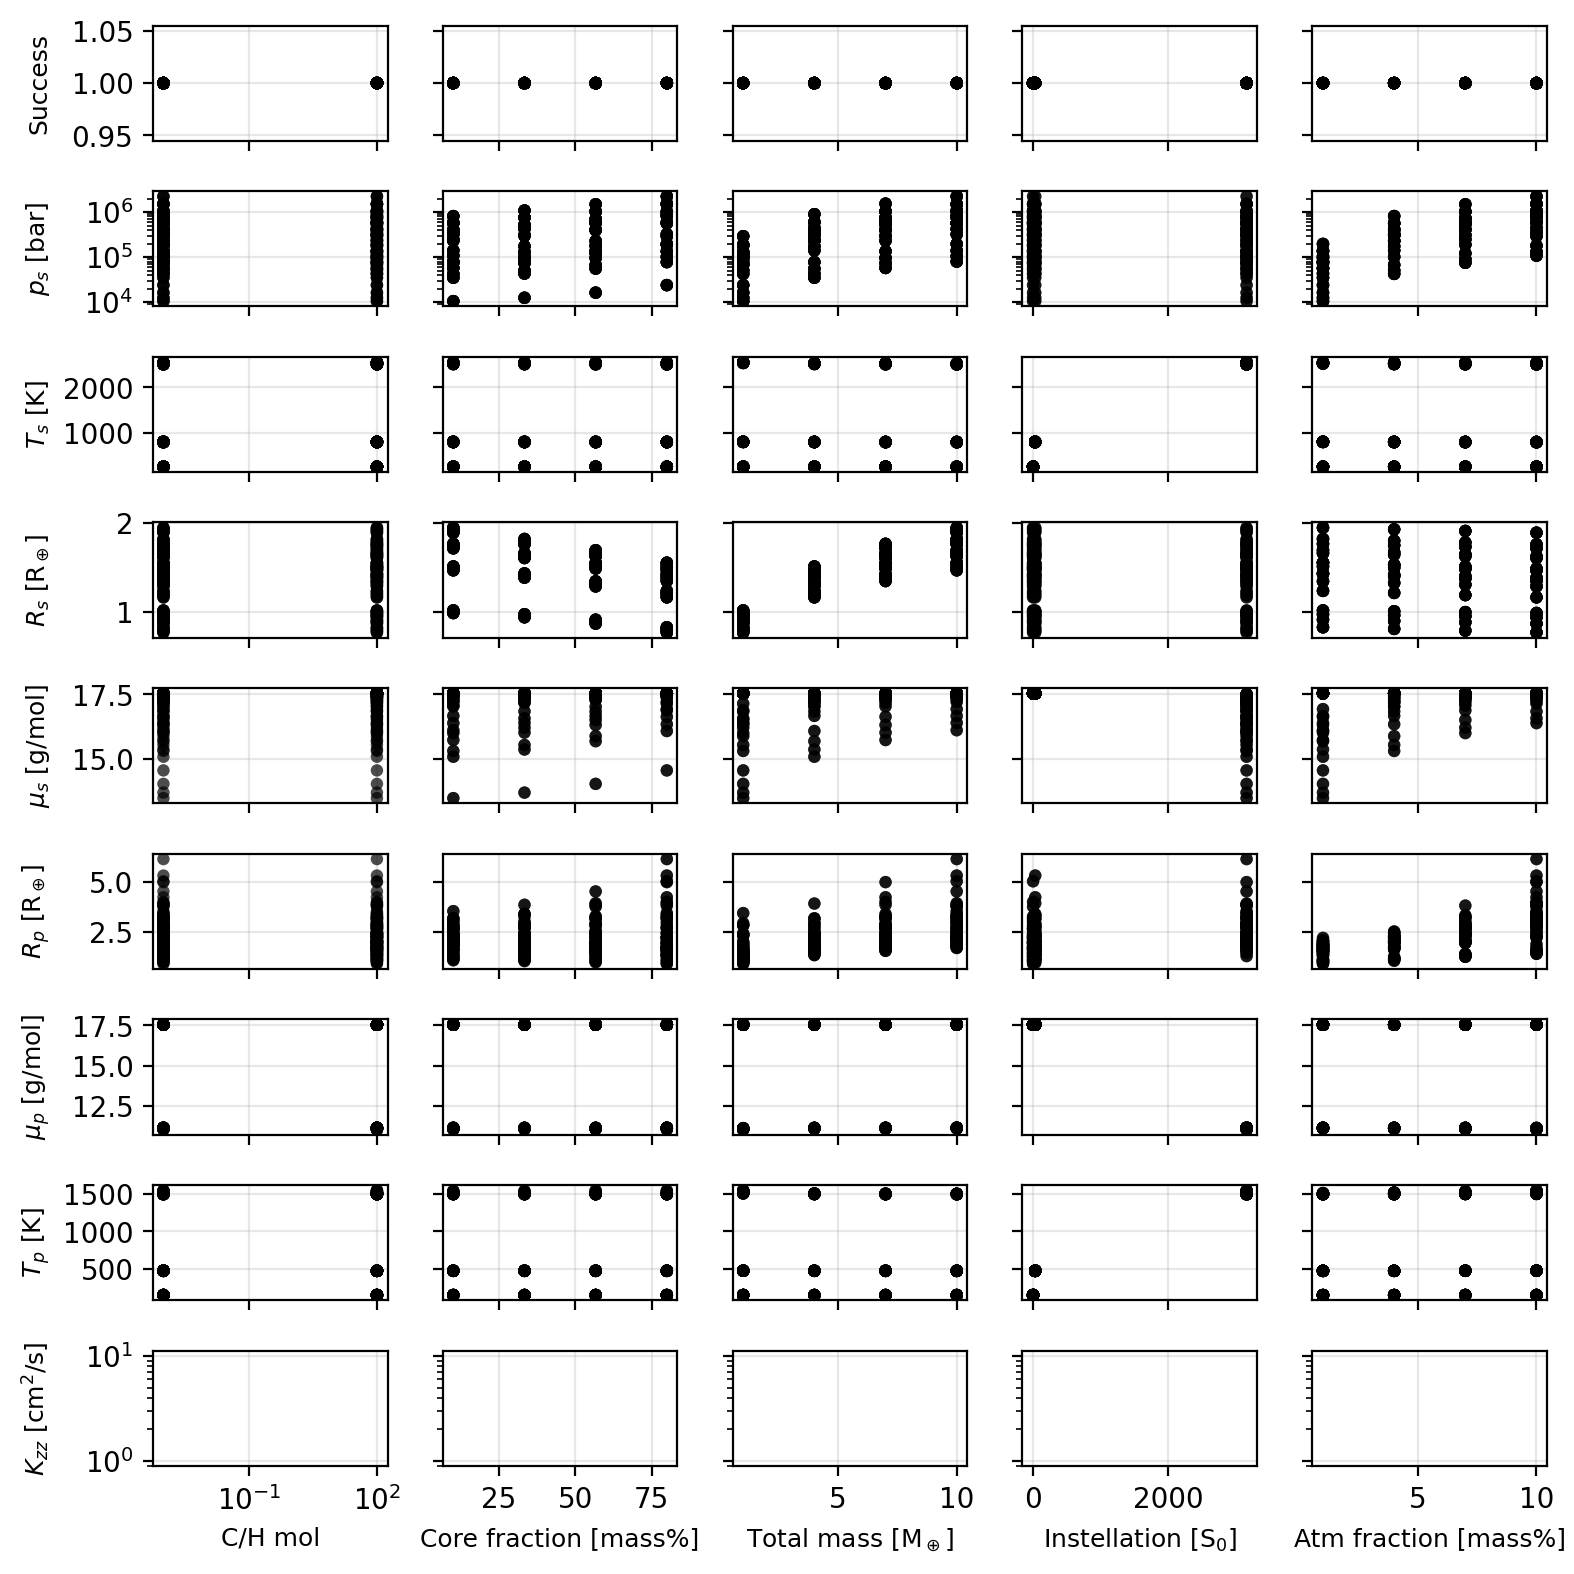

In [12]:

# Create figure with subplots
fig, axes = plt.subplots(len(output_vars), len(input_vars),
                        # figsize=(3*len(input_vars), 2*len(output_vars))
                        figsize=(8,8)
                        )

# If only one row or column, ensure axes is 2D
if len(output_vars) == 1:
    axes = axes.reshape(1, -1)
if len(input_vars) == 1:
    axes = axes.reshape(-1, 1)

# Plot each combination
for i, output_var in enumerate(output_vars):
    for j, input_var in enumerate(input_vars):
        ax = axes[i, j]

        x = np.array(data[input_var]) * units[input_var][0]
        xlabel = units[input_var][2]
        if units[input_var][1]:
            ax.set_xscale("log")

        y = np.array(data[output_var]) * units[output_var][0]
        ylabel = units[output_var][2]
        if units[output_var][1]:
            ax.set_yscale("log")

        # Create scatter plot
        scatter = ax.scatter(x,y, zorder=3, alpha=0.7, s=20,
                                edgecolor='none', linewidth=0.5, color='k')

        # Set labels and title
        if (i == len(output_vars)-1): # or (i == 0):
            ax.set_xlabel(xlabel, fontsize=9)
            if i == 0:
                ax.xaxis.set_label_position('top')
                ax.xaxis.set_tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
        else:
            ax.set_xticklabels([])

        if (j == 0):# or (j == len(input_vars)-1) :
            ax.set_ylabel(ylabel, fontsize=9)
            if (j == len(input_vars)-1):
                ax.yaxis.set_label_position('right')
                ax.yaxis.set_tick_params(right=True, labelright=True, left=False, labelleft=False)
        else:
            ax.set_yticklabels([])

        # Add grid
        ax.grid(True, alpha=0.3, zorder=-2)

        # Format axes
        ax.tick_params(axis='both', which='major', labelsize=10)

fig.tight_layout()
fig.align_ylabels()
fig.align_xlabels()

# Save the plot
fig.savefig(os.path.join(output_dir, "matrix.pdf"), dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

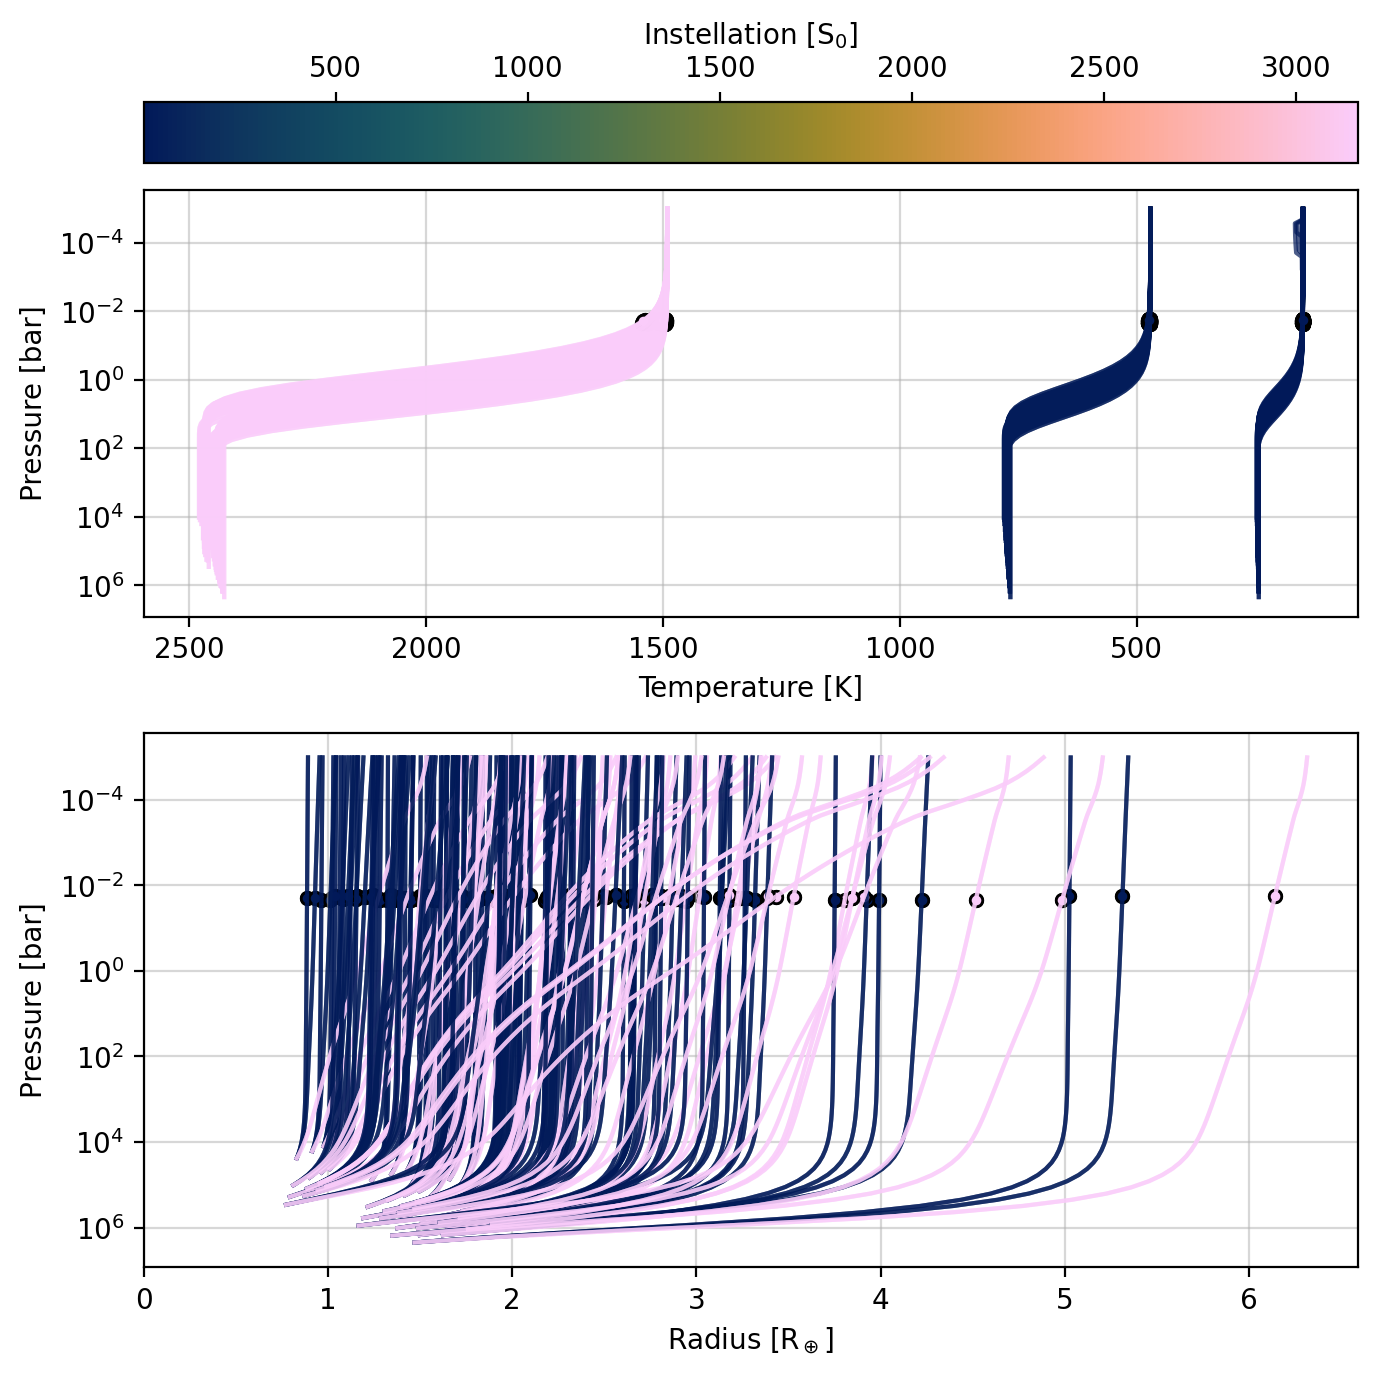

In [9]:
fig, axs = plt.subplots(2,1, figsize=(7,7))
(axt, axb) = axs

key = "instellation"
zunit = units[key][0]
norm = mpl.colors.Normalize(vmin=np.amin(data[key])*zunit, vmax=np.amax(data[key])*zunit)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=batlow)

al = 0.7
for i in range(gridsize):
    col = sm.to_rgba(data.iloc[i][key]*zunit)
    ip = np.argmin(np.abs(data_r[i] - data.iloc[i]["r_phot"]))

    x, y = data_t[i], data_p[i]/bar
    axt.plot(x,y, zorder=2, color=col, alpha=al)
    axt.scatter(x[ip],y[ip], color=col, edgecolors='k', s=20)

    x, y = data_r[i]/R_earth, data_p[i]/bar
    axb.plot(x,y, zorder=2, color=col, alpha=al)
    axb.scatter(x[ip],y[ip], color=col, edgecolors='k', s=20)


axt.invert_xaxis()
axt.set_xlabel("Temperature [K]")
axb.set_xlabel(r"Radius [R$_\oplus$]")
axb.set_xlim(left=0)

for ax in axs:
    ax.set_ylabel("Pressure [bar]")
    ax.set_yscale("log")
    ax.invert_yaxis()
    ax.grid(zorder=-2, alpha=0.5)

fig.colorbar(sm, ax=axt, label=units[key][2], location='top')

fig.tight_layout()
fig.align_ylabels()
fig.savefig(os.path.join(output_dir, "profiles.pdf"), dpi=300, bbox_inches='tight')
plt.show()

In [10]:
exo_named = [["TRAPPIST-1 b","TRAPPIST-1 c", "TRAPPIST-1 d", "TRAPPIST-1 e", "TRAPPIST-1 f", "TRAPPIST-1 g"],
            #  ["L 98-59 b", "L 98-59 c", "L 98-59 d", "L 98-59 e"],
             ["TOI-561 b"],
             ["K2-18 b",],
             ["K2-3 b", "K2-3 c"],
             ["55 Cnc Ae"],
             ["TOI-270 d"]
            ]

exo_colors = [
    "tab:blue", "tab:orange", "tab:green", "tab:purple", "tab:red", "tab:brown",
]

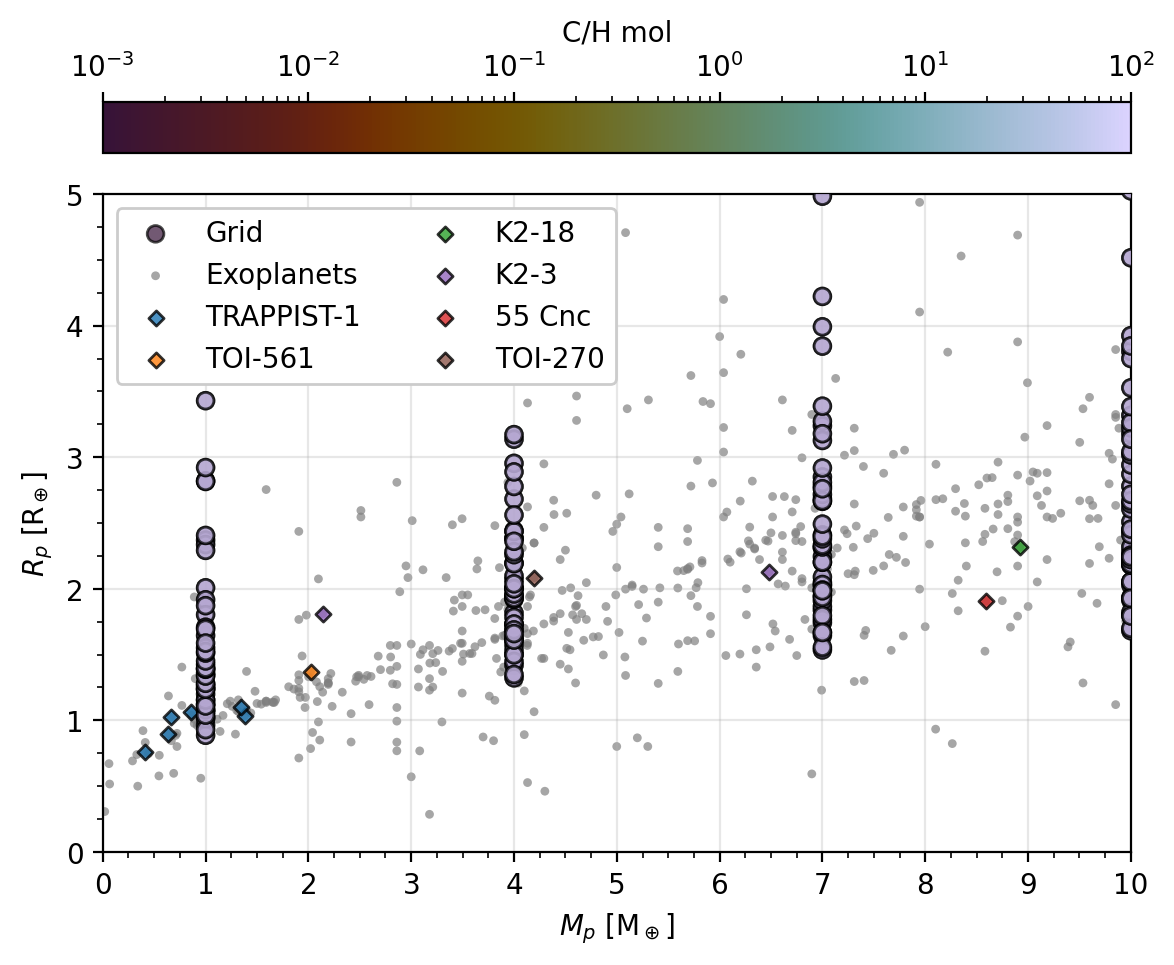

In [16]:
fig,ax = plt.subplots(1,1, figsize=(6,5))

xlim = (0, 10)
ylim = (0, 5)

key = "metal_C"
zunit = units[key][0]
vmin, vmax = np.amin(data[key])*zunit, np.amax(data[key])*zunit
if units[key][1]: # log scale
     norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
else:
    norm = mpl.colors.Normalize(vmin=min, vmax=vmax)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=glasgow)

# Grid results
c = [sm.to_rgba(z) for z in data[key]*zunit]
x,y = data["mass_tot"], data["r_phot"]/R_earth
ax.scatter(x,y, zorder=10, alpha=0.7, edgecolors='k', c=c, label="Grid")

# Plot grid as lines of constant key
# for u in np.unique(data[key]):
#     mask = np.argwhere(data[key][:] == u).flatten()  # get rows with key= this value
#     xx = x[mask]
#     yy = y[mask]
#     mask = mask[np.argsort(xx)]    # sort them in ascending mass order
#     ax.plot(xx[mask], yy[mask], zorder=9, color=sm.to_rgba(u*zunit))

# Zeng2019 curves
# for i,k in enumerate((r"1.0% H$_2$, 500K", r"MgSiO$_3$", r"Earth-like", "Fe")):
#     x,y = mr_curves[k]
#     col = 'hotpink'
#     label = ""
#     # if i == 0:
#     #     label = "Zeng+19"
#     ax.plot(x,y, zorder=7, ls='dotted', color=col, label=label)
#     x0 = xlim[1]*1.01
#     y0 = y[np.argmin(np.abs(x-x0))]
#     ax.text(x0, y0, k, ha='left', va='center', color=col, fontsize=9)

# Exoplanets
ax.scatter(exo_dat["mass"] * unit_Mjup / unit_Mear,
           exo_dat["radius"] * unit_Rjup / unit_Rear,
            color='gray', s=10, alpha=0.7, zorder=0, label="Exoplanets", edgecolors='none', rasterized=True)

# Named exoplanets
for j,s in enumerate(exo_named):
    col = exo_colors[j]
    for i,p in enumerate(s):
        if i == 0:
            lbl = p[:-2]
        else:
            lbl = None
        row = exo_dat.loc[exo_dat['name'] == p].iloc[0]

        x = row["mass"] * unit_Mjup / unit_Mear
        y = row["radius"] * unit_Rjup / unit_Rear

        a = ax.scatter(x,y, s=15, label=lbl, alpha=0.8, zorder=8,
                            color=col, ec='k', marker='D')


ax.set_xlabel(r"$M_p$ [M$_\oplus$]")
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1.0))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
ax.set_xlim(xlim)

ax.set_ylabel(r"$R_p$ [R$_\oplus$]")
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1.0))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
ax.set_ylim(ylim)

leg = ax.legend(framealpha=1, ncols=2)
leg.set_zorder(100)
ax.grid(alpha=0.3, zorder=-2)
fig.colorbar(sm, ax=ax, label=units[key][2], location='top')

fig.tight_layout()
fig.savefig(os.path.join(output_dir, "mass_radius.pdf"), dpi=300, bbox_inches='tight')
plt.show()